# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="C:\deep-reinforcement-learning\p1_navigation\Banana_Windows_x86_64\Banana_Windows_x86_64\Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [6]:
env.close

<bound method UnityEnvironment.close of <unityagents.environment.UnityEnvironment object at 0x000001C0D998E860>>

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

## Implementation


Importing necessary libraries and declaration of some of the hyperparameters used by the model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
import random
import matplotlib.pyplot as plt

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

plt.ion() # Turn on interactive mode

#### QNetwork
A class for constructing an instance of a neural network with, an input layer, one hidden layer and an output layer
The object is constructed with a size of the input space as well ass the size of the output space.

In [7]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, hidden_layers):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            hidden_layers: list of the sizes of the hidden layers
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed) #Setting the seed for the random generator in Pytorch
        # Sets up all layers with linear transformations
        # Add the input layer to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])
        
        # Add the remaining hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        # Add the output layer
        self.output = nn.Linear(hidden_layers[-1], action_size)
        

    def forward(self, state):
        # Forward propagation
        # relu is a non-linear activation function
        # F is the pyTorch functional module
        x = state
        for linear in self.hidden_layers: # Pass through hidden layers
            x = F.relu(linear(x))
            
        return self.output(x) # Return the output of the output layer
            
        

### ReplayBuffer

Fixed-size buffer to store experience tuples and allows for sampling of a random batch of experience tuples from the memory

In [8]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Agent
A class for constructing an instance of an agent, that can act according to the states represented to it and learn from rewards given to it
The agent constructs two instances of the QNetwork class, one for producing the output and a target network that represents the target for the current state the agent is in.
The agent also initialises a replayBuffer to store tuples of reward, state and action to use for learning.

The an agent object can use the following methods:
1. **act**: The agent chooses an action with an epsilon-greedy policy. So with low probability epsilon will the agent pick a random action, otherwise it will pick the action with the maximum value for the current output of the QNetwork
2. **step**: The agent adds the current experience (reward, state and action) to the replay buffer and for every **UPDATE_EVERY** timestep it **learns** from the experience pool.
3. **learn** the agent updates its QNetworks by learning from a random experience sample from the replayBuffer. The agent updates the target model by calling the function **soft_update**

In [11]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Perceptrons in layers of networks
        hidden_layers = [50, 50]
    
        # Q-Networks
        self.qnetwork_local = QNetwork(state_size, action_size, seed, hidden_layers).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed, hidden_layers).to(device)
        # Constructing the optimizer that will hold the current state and update parameters (weights) based on computed gradients
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        
        # Make current state into a Tensor that can be passes as input to the network
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        # Set network in evaluation mode to prevent things like dropout from happening
        self.qnetwork_local.eval()
        
        # We don't need to backpropagate, so turn off the autograd engine
        with torch.no_grad():
            # Do a forward pass through the network
            action_values = self.qnetwork_local(state)
        
        # Put network back into training mode
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return int(np.argmax(action_values.cpu().data.numpy()))
        else:
            actions = np.arange(self.action_size)
            return random.choice(actions.astype(int))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad() # Reset the gradients to prevent accumulation
        loss.backward()            # Compute gradients
        self.optimizer.step()      # Update weights

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU) 
        

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)



### Initialising the agent

In [12]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)


### Training the agent
The function runs maximum 1800 episodes of training the agent and terminates in the case the agent achieves an average score of 13 in 100 episodeds. When the agent finishes training the model weights are saved for later use.
In one of the cells below it is also possible to load a set of pre-trained weights into the model that the agent uses to avoid training

In [14]:


def agent_train(n_episodes=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []
    scores_window_100 = deque(maxlen=100)
    scores_window_20 = deque(maxlen=20)
    
    solved = False
    
    epsilon = eps_start
    
    for episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]        # Reset the environment
        state = env_info.vector_observations[0]                  # Initial state
        score = 0                                                # Initial score
        while True:
            action = agent.act(state, epsilon)                   # Agent chooses action based on current state
            env_info = env.step(action)[brain_name]              # Send the action to the environment
            next_state = env_info.vector_observations[0]         # Get the next state based on the action
            reward = env_info.rewards[0]                         # Get the reward from taking the action
            done = env_info.local_done[0]                        
            agent.step(state, action, reward, next_state, done)  # Update the agent with the experience
            score += reward                                      # Accumulate score
            state = next_state                                   # Roll over the state to next time step
            
            # Check if current episode is terminated
            if done:                                             
                break
        
        # Save score from current episode
        scores_window_100.append(score)
        scores_window_20.append(score)
        scores.append(score)
        
        # Update epsilon
        epsilon = max(eps_end, eps_decay*epsilon)                

        # Print out current episodes and average score
        if episode % 20 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window_20)))
            
        #elif episode % 20 == 0:
        #    print('\rEpisode {}' .format(episode))
            
        if np.mean(scores_window_100)>=13.0 and not solved:
            # Agent has reached target average score. Ending training
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode-100, np.mean(scores_window_100)))
            #torch.save(agent.qnetwork_local.state_dict(), 'model.pth') # Save model weights so the model weights can be loaded and training skipped next time running the notebook
            solved = True;
            
    torch.save(agent.qnetwork_local.state_dict(), 'model.pth')    
    return scores


end_scores = agent_train()


Episode 20	Average Score: -0.10
Episode 40	Average Score: 0.45
Episode 60	Average Score: 0.40
Episode 80	Average Score: 0.45
Episode 100	Average Score: 0.95
Episode 120	Average Score: 2.15
Episode 140	Average Score: 3.25
Episode 160	Average Score: 4.10
Episode 180	Average Score: 4.85
Episode 200	Average Score: 6.30
Episode 220	Average Score: 5.40
Episode 240	Average Score: 6.90
Episode 260	Average Score: 6.80
Episode 280	Average Score: 7.40
Episode 300	Average Score: 8.15
Episode 320	Average Score: 7.50
Episode 340	Average Score: 9.85
Episode 360	Average Score: 9.80
Episode 380	Average Score: 10.90
Episode 400	Average Score: 13.55
Episode 420	Average Score: 13.80
Episode 440	Average Score: 12.20
Episode 460	Average Score: 14.10

Environment solved in 363 episodes!	Average Score: 13.01
Episode 480	Average Score: 13.45
Episode 500	Average Score: 14.25
Episode 520	Average Score: 13.40
Episode 540	Average Score: 14.80
Episode 560	Average Score: 14.50
Episode 580	Average Score: 14.00
Episod

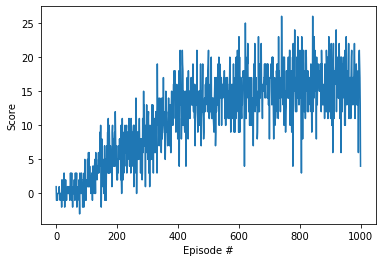

In [15]:
# plot the scores
Scores_plot = plt.figure()
ax = Scores_plot.add_subplot(111)
plt.plot(np.arange(len(end_scores)), end_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')

plt.savefig("Scores_plot.png")
plt.show()

### Initialising agent from saved weights
Run the cell block below to load the pre-trained weights into the model.

In [16]:
agent.qnetwork_local.load_state_dict(torch.load('model.pth'))
agent.qnetwork_local.eval()

QNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=37, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
  )
  (output): Linear(in_features=50, out_features=4, bias=True)
)

### Showing the agent in action
Setting train_mode to False in the Unity environment allows to show the agent collecting bananas in one episode.

In [56]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state, 0)                   # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 19.0
